In [1]:
# load required libraries
options(stringsAsFactors = F)
options (repr.plot.width = 12, repr.plot.height = 5)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(ggplot2)
library(sctransform)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(dplyr)
library(Matrix)
library(Hmisc)
library(ggsci)
library(viridis)
library(RColorBrewer)
library(ggrepel)
library(cowplot)
})
set.seed(123)

In [2]:
# load DCM samples
sample <- readRDS("./matrix/subsample_DCM_annotated_level1.rds")
Idents(sample) <- sample$celltype
sample <- subset(sample, idents = "EC")
sample

An object of class Seurat 
33538 features across 7344 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

Centering and scaling data matrix



An object of class Seurat 
33538 features across 7344 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


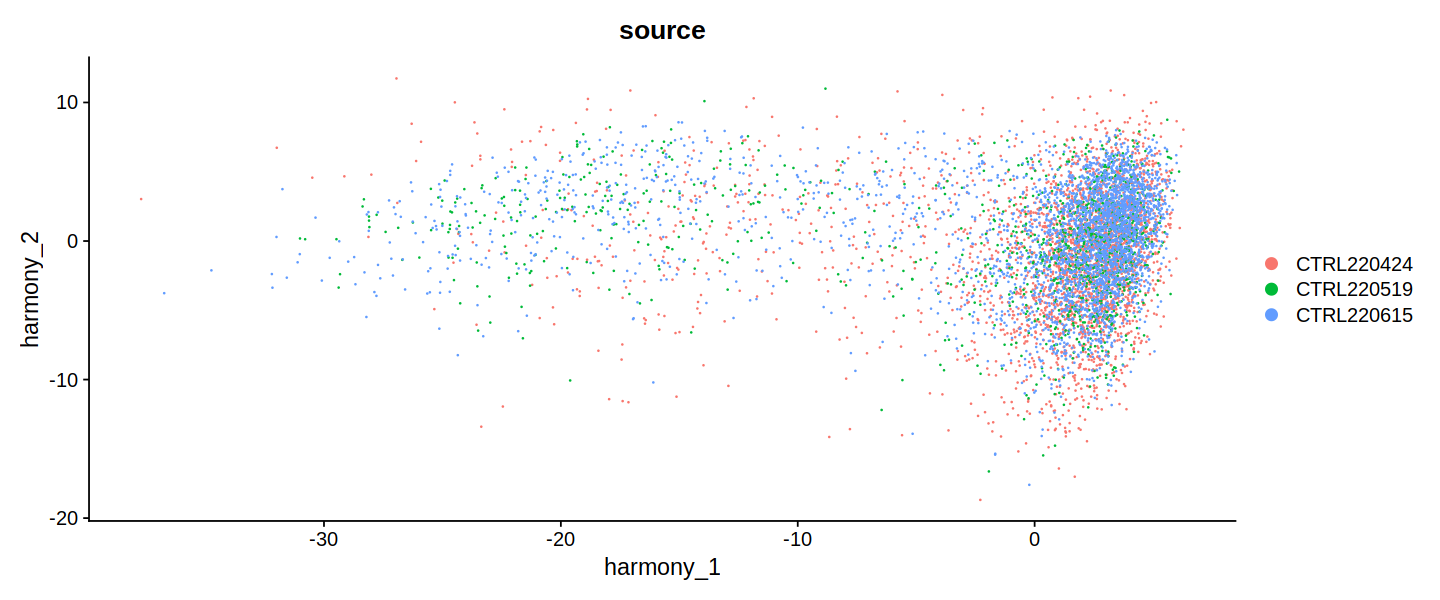

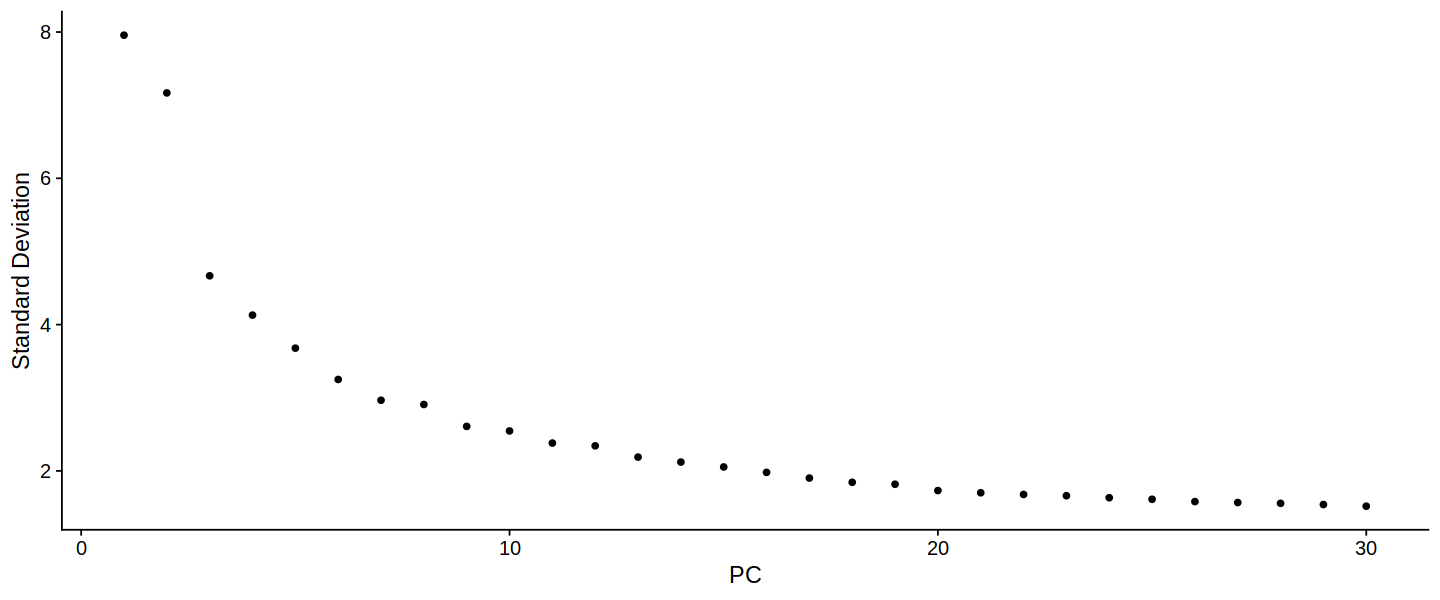

In [3]:
# normalize sample
sample <- NormalizeData(sample, normalization.method = "LogNormalize", scale.factor = 10000)

# find variable Genes and scale data
sample <- FindVariableFeatures(sample, selection.method = "vst")
sample <- ScaleData(sample)
sample

# run pca and harmony
sample <- RunPCA(sample, verbose = FALSE)
sample <- RunHarmony(sample, group.by.vars = "source", verbose = FALSE)
DimPlot(sample, reduction = "harmony", pt.size = 0.1, group.by = "source")
ElbowPlot(sample, ndims = 30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


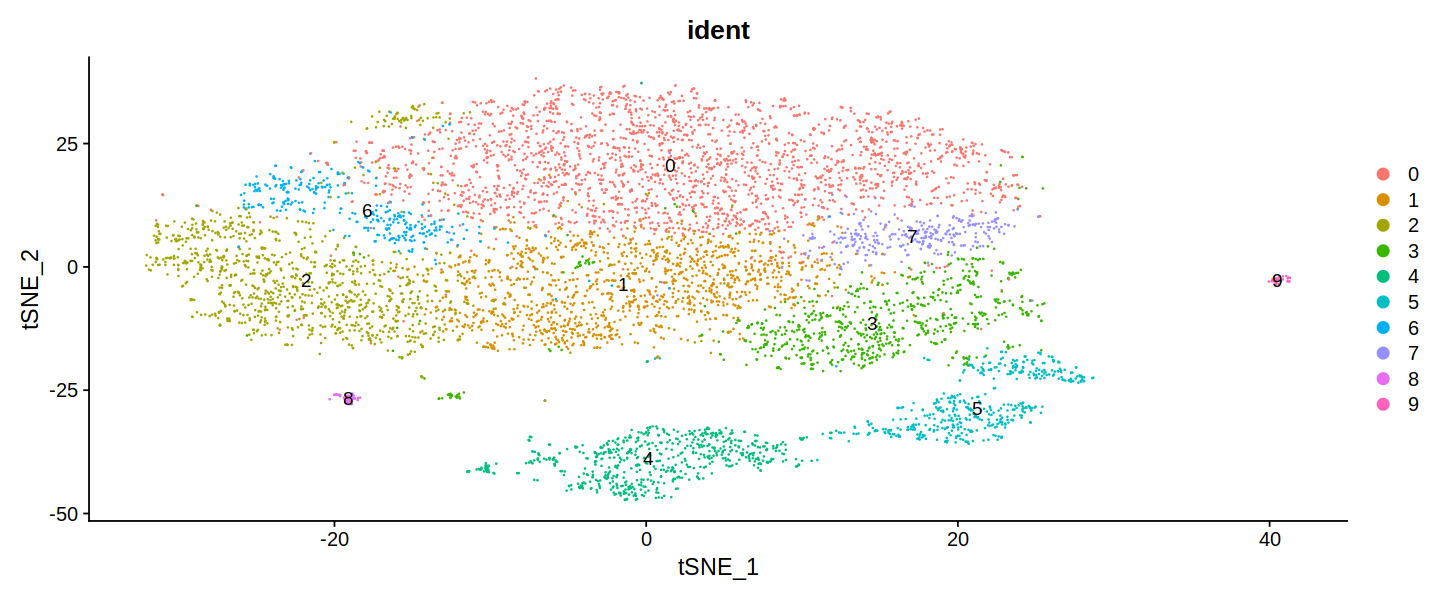

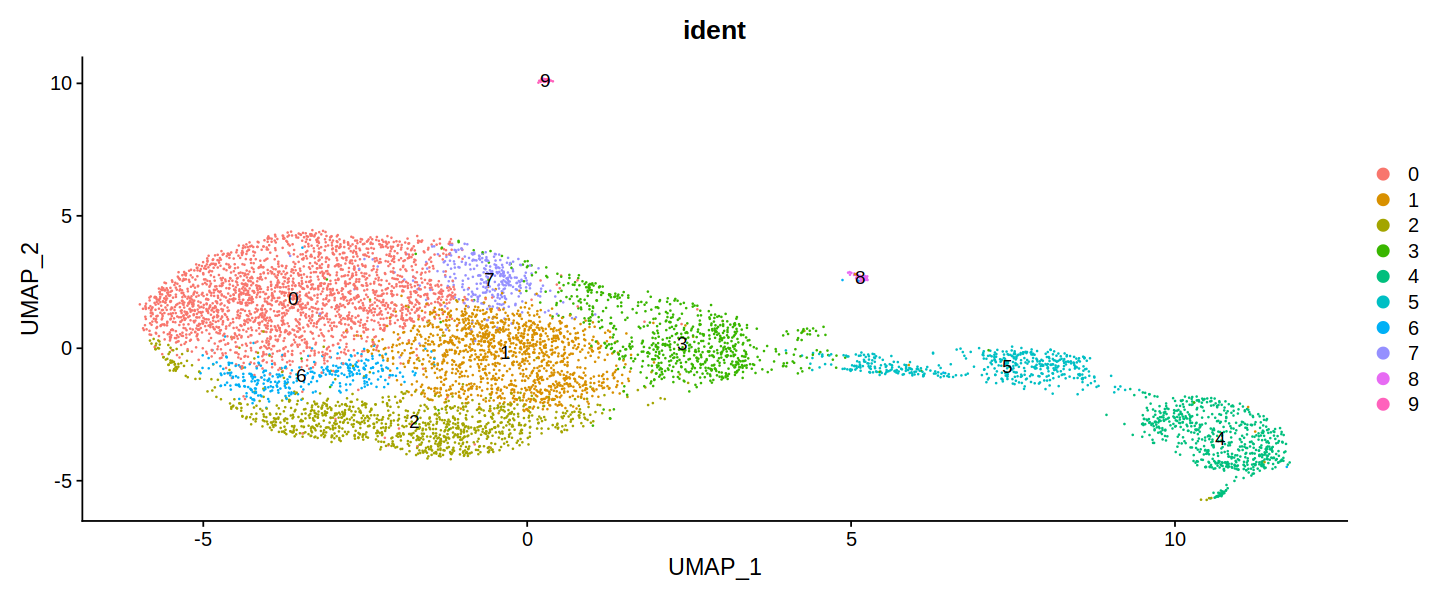

In [4]:
# dimension reduction and clustering
pca_dims <- 1:25
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE, return.model = TRUE)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)
DimPlot(sample, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)

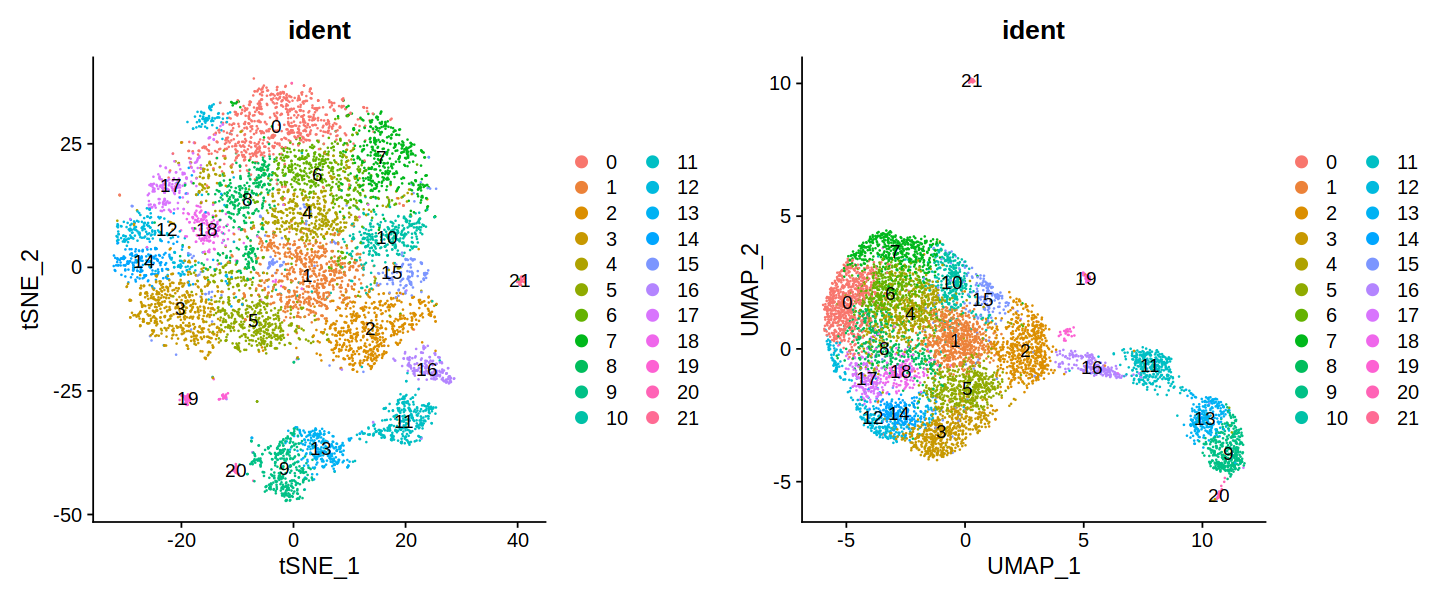

In [5]:
# add resolution and plot tsne/umap by ident
sample <- FindClusters(sample, resolution = 2, verbose = FALSE)
a <- DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)
b <- DimPlot(sample, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)
plot_grid(a, b, ncol = 2)

Centering and scaling data matrix



An object of class Seurat 
33538 features across 7205 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


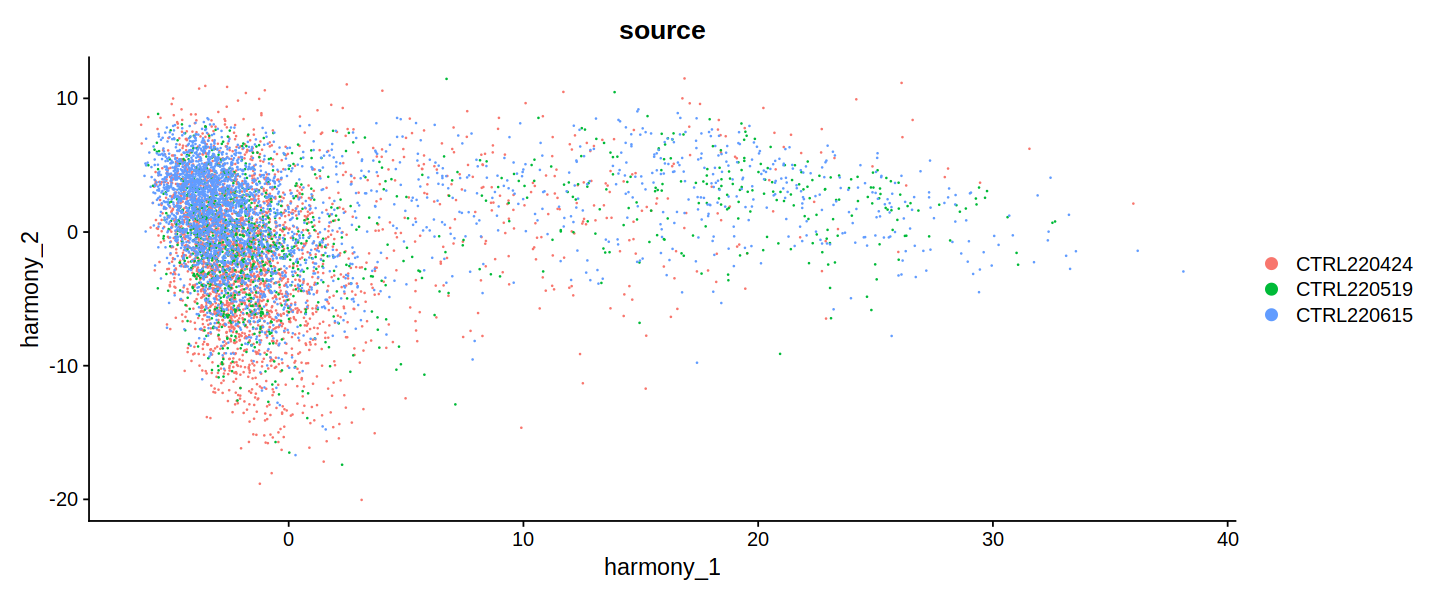

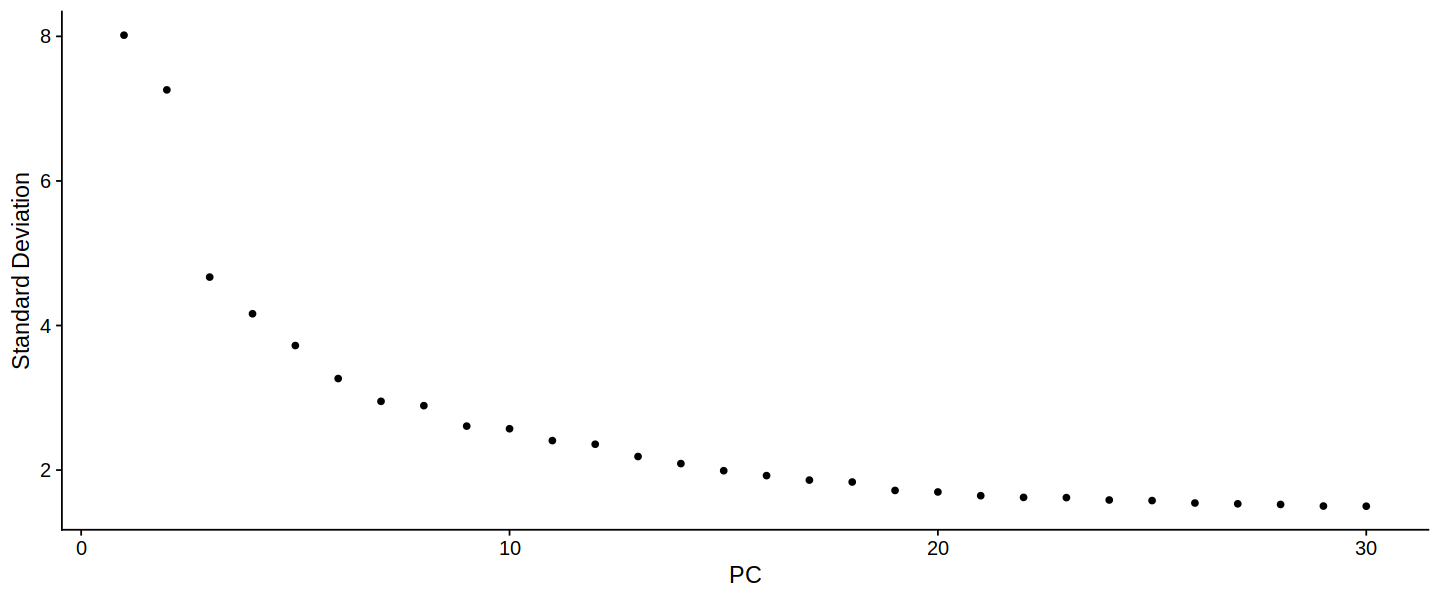

In [6]:
# remove cluster 19, 20, 21
sample <- subset(sample, idents = c(19, 20, 21), invert = T)
sample <- NormalizeData(sample, normalization.method = "LogNormalize", scale.factor = 10000)

# find variable Genes and scale data
sample <- FindVariableFeatures(sample, selection.method = "vst")
sample <- ScaleData(sample)
sample

# run pca and harmony
sample <- RunPCA(sample, verbose = FALSE)
sample <- RunHarmony(sample, group.by.vars = "source", verbose = FALSE)
DimPlot(sample, reduction = "harmony", pt.size = 0.1, group.by = "source")
ElbowPlot(sample, ndims = 30)

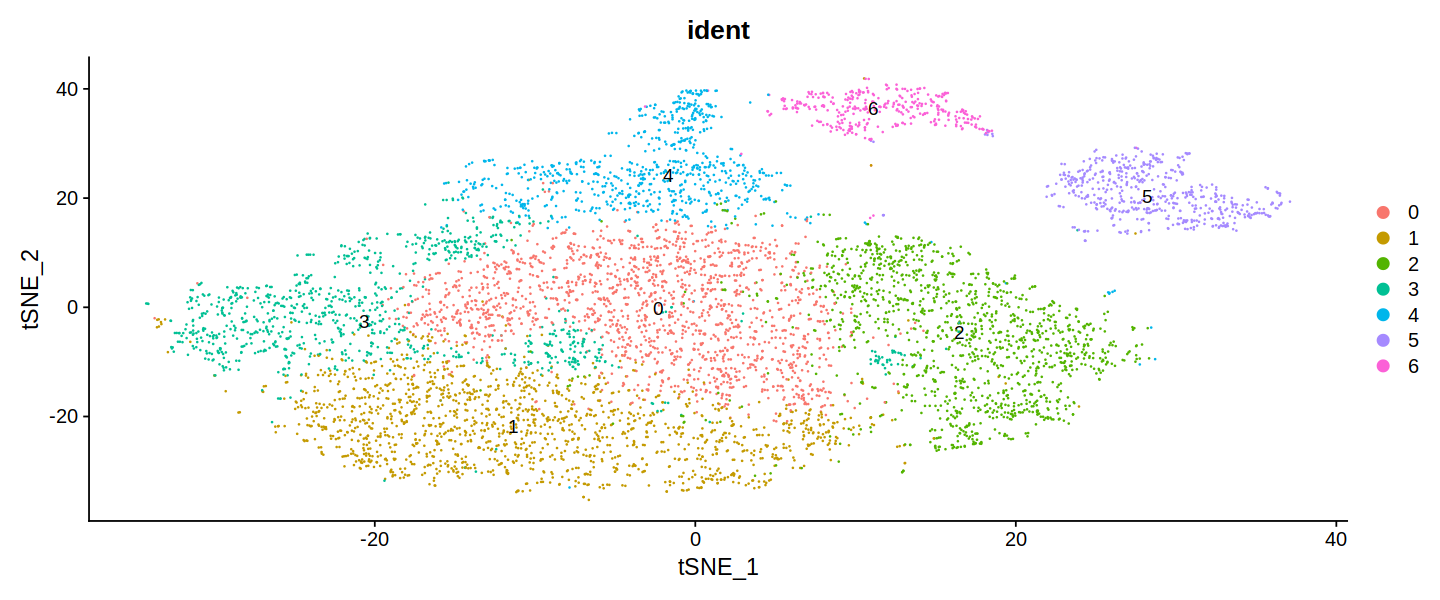

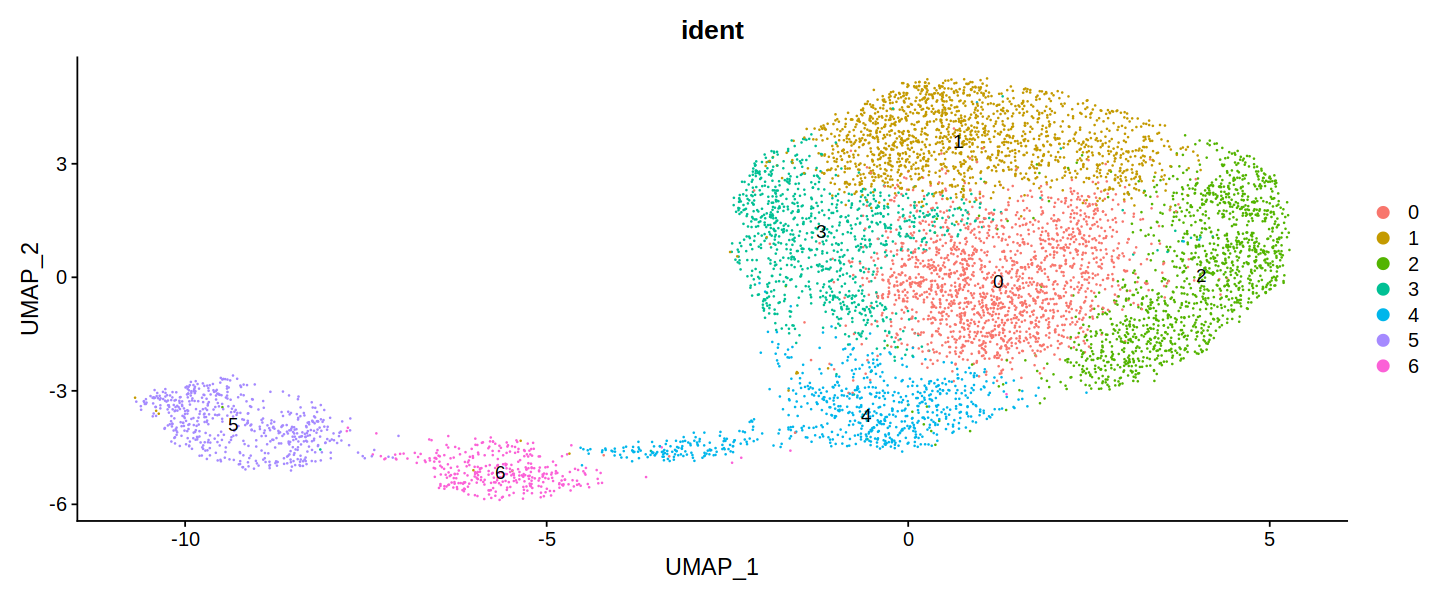

In [7]:
# dimension reduction and clustering
pca_dims <- 1:25
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE, return.model = T)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)
DimPlot(sample, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)

In [8]:
# save the sample
saveRDS(sample, file = "./rds/sample_DCM_EC_clean.rds")

In [9]:
# load the sample
sample <- readRDS("./rds/sample_DCM_EC_clean.rds")
sample

An object of class Seurat 
33538 features across 7205 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

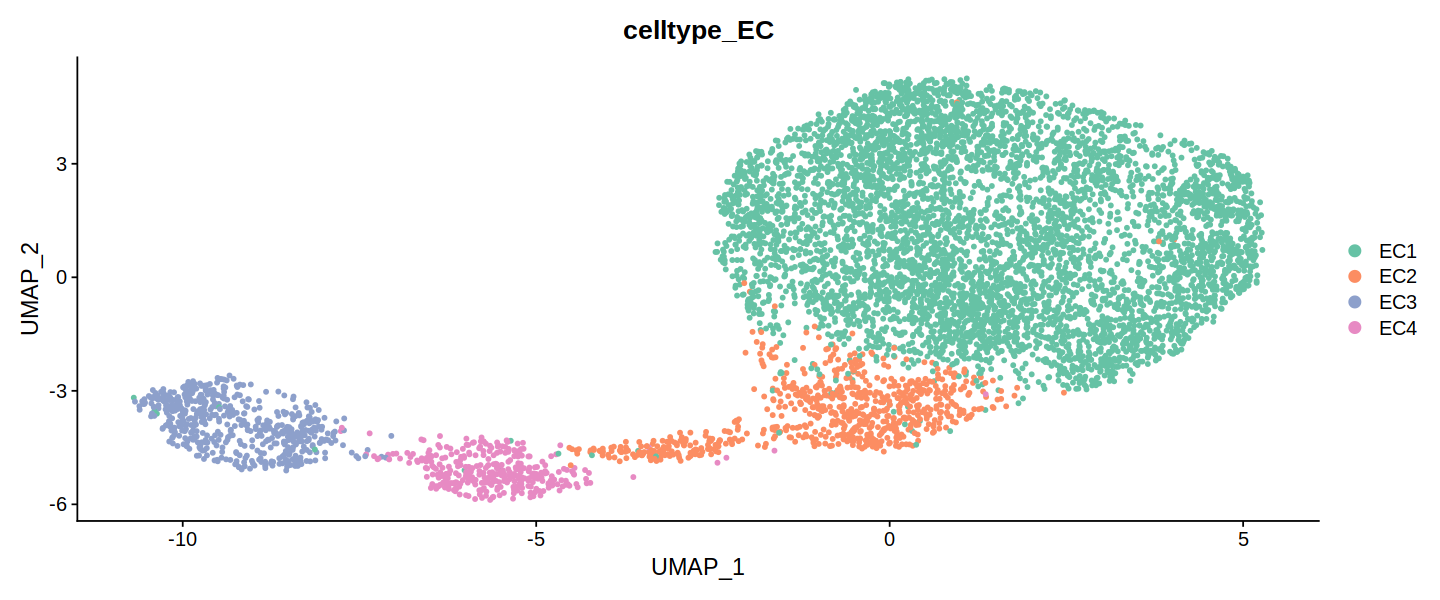

In [10]:
# EC sub-celltype annotation
cluster = c(0:6)
celltype_EC = c("EC1","EC1","EC1","EC1","EC2","EC3","EC4")
sample$celltype_EC = plyr::mapvalues(x=sample$seurat_clusters, from=cluster, to=celltype_EC)
DimPlot(sample, label=F, reduction = "umap", group.by = "celltype_EC", pt.size = 1, cols = c('#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'))

In [11]:
# find markers for each EC subcluster
Idents(sample) <- sample$celltype_EC
markers_EC_sub <- FindAllMarkers(sample, only.pos = T, verbose = F)
write.csv(markers_EC_sub, "meta/markers_DCM_by_celltype_EC.csv")

In [12]:
# GO_BP Analysis using clusterProfiler
library(gtools)
markers <- read.csv("./meta/markers_DCM_by_celltype_EC.csv", row.names = 1)
markers_seurat_significant <- subset(markers, abs(avg_log2FC) >= 0.25 & p_val_adj <= 0.05)

# Get Unique cell type
celltypes <- unique(markers_seurat_significant$cluster)

# Initialize a empty list to store GO_BP results
go_results <- list()

# GO_BP analysis for each cell types
for (celltype in celltypes) {
    marker_genes <- markers_seurat_significant$gene[markers_seurat_significant$cluster == celltype]
    
    # Skip cell types with less than 20 significant marker genes
    if (length(marker_genes) < 20){
        next
    }
    
    #  Perform GO_BP enrichment analysis
    ego <- enrichGO(gene = marker_genes, 
                    OrgDb = org.Hs.eg.db,
                    keyType = 'SYMBOL',
                    ont = 'BP',
                    pAdjustMethod = 'BH',
                    pvalueCutoff = 0.05,
                    qvalueCutoff = 0.05)
    
    # Remove redundant GO_BP terms
    # ego_simplified <- simplify(ego, cutoff = 0.7, by = "p.adjust", select_fun = min)
    ego_simplified <- ego
    if (nrow(ego_simplified@result) > 0) {
        
        # Add celltype column to the simplified GO_BP result
        ego_simplified@result$celltype <- celltype
        
        # Store the GO_BP in go_results
        go_results[[celltype]] <- ego_simplified
    }
}

# Merge GO_BP results from all cell types
merged_go_results <- do.call(rbind, lapply(go_results, function(x) x@result))

# Move the celltype columns to the first column
merged_go_results <- merged_go_results[, c('celltype', setdiff(colnames(merged_go_results), 'celltype'))]

# sort the celltype column and save the data
merged_go_results <- merged_go_results[mixedorder(merged_go_results$celltype, merged_go_results$p.adjust, decreasing = F), ]
write.table(merged_go_results, './meta/EC_sub_DCM_celltype_markers_GO_BP.tsv', sep = '\t', quote = F, row.names = F, col.names = T)
head(merged_go_results)

# subset the significant GO_BP enrichment results
merged_go_results_significant <- subset(merged_go_results, p.adjust <= 0.05)
write.table(merged_go_results_significant, './meta/EC_sub_DCM_celltype_markers_GO_BP_significant.tsv', sep = '\t', quote = F, row.names = F, col.names = T)
head(merged_go_results_significant)

,celltype,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
EC1.GO:0002181,EC1,GO:0002181,cytoplasmic translation,48/521,159/18614,2.630375e-36,1.199451e-32,9.743463e-33,RPS6/RPS18/RPS2/RPS23/RPL32/RPL12/RPS19/RPL37/RPL26/RPL3/RPL34/PABPC1/RPS14/RPS8/RPS3/RPS15/RPL13/RPS15A/RPL10/RPL31/RPS4X/RPS9/RPLP0/RPL11/RPL39/RPL30/RPL7/RPL10A/RPL41/RPL35A/RACK1/RPS24/RPL5/RPL4/RPL13A/YBX3/RPL28/RPL7A/RPL14/RPL38/RPL36A/RPS21/EIF3E/RPS20/RPS3A/EIF3L/RPS5/EIF4A1,48
EC1.GO:0051348,EC1,GO:0051348,negative regulation of transferase activity,30/521,279/18614,3.051461e-10,6.957331e-07,5.651627e-07,NR2F2/CBLB/PIP4K2A/TRIB1/SPRY1/RPL37/CDKN1A/SH3BP5/HIPK3/RPS15/LRP5/PPP2R5A/RPL11/PRKAG2/RACK1/RPL5/TNFAIP3/SPRED1/DNAJA1/NCAPG2/ZFP36/RPS20/SNCA/CORO1C/NPM1/GPRC5A/MIDN/ERRFI1/ABL1/HEXIM1,30
EC1.GO:0042326,EC1,GO:0042326,negative regulation of phosphorylation,34/521,383/18614,3.225418e-09,3.440557e-06,2.794857e-06,NR2F2/CBLB/PIP4K2A/TRIB1/CNKSR3/SPRY1/ENG/SOCS3/IER3/CDKN1A/SH3BP5/HIPK3/LRP5/PPP2R5A/PRKAG2/RACK1/DUSP6/TNFAIP3/SPRED1/DNAJA1/NUPR1/NCAPG2/SNCA/PLPP3/HGF/CORO1C/JUN/NPM1/GPRC5A/MIDN/ERRFI1/ABL1/HEXIM1/MYADM,34
EC1.GO:0002399,EC1,GO:0002399,MHC class II protein complex assembly,8/521,16/18614,3.772541e-09,3.440557e-06,2.794857e-06,HLA-DQA1/HLA-DRA/HLA-DPA1/HLA-DPB1/HLA-DQB1/HLA-DRB1/HLA-DMA/HLA-DRB5,8
EC1.GO:0002503,EC1,GO:0002503,peptide antigen assembly with MHC class II protein complex,8/521,16/18614,3.772541e-09,3.440557e-06,2.794857e-06,HLA-DQA1/HLA-DRA/HLA-DPA1/HLA-DPB1/HLA-DQB1/HLA-DRB1/HLA-DMA/HLA-DRB5,8
EC1.GO:0045936,EC1,GO:0045936,negative regulation of phosphate metabolic process,36/521,439/18614,9.056778e-09,6.260646e-06,5.085691e-06,NR2F2/CBLB/PIP4K2A/TRIB1/CNKSR3/SPRY1/ENG/SOCS3/IER3/CDKN1A/SH3BP5/HIPK3/LRP5/PPP2R5A/PRKAG2/RACK1/DUSP6/TNFAIP3/SPRED1/DNAJA1/NUPR1/PPP1R15A/NCAPG2/SNCA/PLPP3/HGF/CORO1C/JUN/NPM1/GPRC5A/MIDN/MFHAS1/ERRFI1/ABL1/HEXIM1/MYADM,36


,celltype,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
EC1.GO:0002181,EC1,GO:0002181,cytoplasmic translation,48/521,159/18614,2.630375e-36,1.199451e-32,9.743463e-33,RPS6/RPS18/RPS2/RPS23/RPL32/RPL12/RPS19/RPL37/RPL26/RPL3/RPL34/PABPC1/RPS14/RPS8/RPS3/RPS15/RPL13/RPS15A/RPL10/RPL31/RPS4X/RPS9/RPLP0/RPL11/RPL39/RPL30/RPL7/RPL10A/RPL41/RPL35A/RACK1/RPS24/RPL5/RPL4/RPL13A/YBX3/RPL28/RPL7A/RPL14/RPL38/RPL36A/RPS21/EIF3E/RPS20/RPS3A/EIF3L/RPS5/EIF4A1,48
EC1.GO:0051348,EC1,GO:0051348,negative regulation of transferase activity,30/521,279/18614,3.051461e-10,6.957331e-07,5.651627e-07,NR2F2/CBLB/PIP4K2A/TRIB1/SPRY1/RPL37/CDKN1A/SH3BP5/HIPK3/RPS15/LRP5/PPP2R5A/RPL11/PRKAG2/RACK1/RPL5/TNFAIP3/SPRED1/DNAJA1/NCAPG2/ZFP36/RPS20/SNCA/CORO1C/NPM1/GPRC5A/MIDN/ERRFI1/ABL1/HEXIM1,30
EC1.GO:0042326,EC1,GO:0042326,negative regulation of phosphorylation,34/521,383/18614,3.225418e-09,3.440557e-06,2.794857e-06,NR2F2/CBLB/PIP4K2A/TRIB1/CNKSR3/SPRY1/ENG/SOCS3/IER3/CDKN1A/SH3BP5/HIPK3/LRP5/PPP2R5A/PRKAG2/RACK1/DUSP6/TNFAIP3/SPRED1/DNAJA1/NUPR1/NCAPG2/SNCA/PLPP3/HGF/CORO1C/JUN/NPM1/GPRC5A/MIDN/ERRFI1/ABL1/HEXIM1/MYADM,34
EC1.GO:0002399,EC1,GO:0002399,MHC class II protein complex assembly,8/521,16/18614,3.772541e-09,3.440557e-06,2.794857e-06,HLA-DQA1/HLA-DRA/HLA-DPA1/HLA-DPB1/HLA-DQB1/HLA-DRB1/HLA-DMA/HLA-DRB5,8
EC1.GO:0002503,EC1,GO:0002503,peptide antigen assembly with MHC class II protein complex,8/521,16/18614,3.772541e-09,3.440557e-06,2.794857e-06,HLA-DQA1/HLA-DRA/HLA-DPA1/HLA-DPB1/HLA-DQB1/HLA-DRB1/HLA-DMA/HLA-DRB5,8
EC1.GO:0045936,EC1,GO:0045936,negative regulation of phosphate metabolic process,36/521,439/18614,9.056778e-09,6.260646e-06,5.085691e-06,NR2F2/CBLB/PIP4K2A/TRIB1/CNKSR3/SPRY1/ENG/SOCS3/IER3/CDKN1A/SH3BP5/HIPK3/LRP5/PPP2R5A/PRKAG2/RACK1/DUSP6/TNFAIP3/SPRED1/DNAJA1/NUPR1/PPP1R15A/NCAPG2/SNCA/PLPP3/HGF/CORO1C/JUN/NPM1/GPRC5A/MIDN/MFHAS1/ERRFI1/ABL1/HEXIM1/MYADM,36


In [13]:
# get the top10 terms of each EC
top5_go_result <- merged_go_results_significant %>% group_by(celltype) %>% top_n(2)
top5_go <- top5_go_result$Description
go_cytokine_chemokine <- grep(pattern = "cytok|Cytok|chemo|Chemo", x = merged_go_results_significant$Description, value = T)
top_go_terms <- unique(c(top5_go, go_cytokine_chemokine))
top_go_terms

Selecting by Count


[1] "cytoplasmic translation"                                      
 [2] "negative regulation of phosphate metabolic process"           
 [3] "negative regulation of phosphorus metabolic process"          
 [4] "positive regulation of cell adhesion"                         
 [5] "ameboidal-type cell migration"                                
 [6] "actin filament organization"                                  
 [7] "cell junction assembly"                                       
 [8] "small GTPase mediated signal transduction"                    
 [9] "cell-substrate adhesion"                                      
[10] "ossification"                                                 
[11] "cytokine-mediated signaling pathway"                          
[12] "negative chemotaxis"                                          
[13] "positive regulation of cytokine production"                   
[14] "cell chemotaxis"                                              
[15] "leukocyte chemotaxis"                                         
[16] "positive chemotaxis"                                          
[17] "neutrophil chemotaxis"                                        
[18] "positive regulation of chemotaxis"                            
[19] "regulation of chemotaxis"                                     
[20] "granulocyte chemotaxis"                                       
[21] "positive regulation of positive chemotaxis"                   
[22] "regulation of positive chemotaxis"                            
[23] "regulation of cytokine production involved in immune response"
[24] "cytokine production involved in immune response"              
[25] "cytokinesis"                                                  
[26] "regulation of leukocyte chemotaxis"                           
[27] "endothelial cell chemotaxis"                                  
[28] "mitotic cytokinesis"                                          
[29] "mast cell chemotaxis"                                         
[30] "regulation of endothelial cell chemotaxis"                    
[31] "T-helper 2 cell cytokine production"                          
[32] "regulation of T-helper 2 cell cytokine production"            
[33] "positive regulation of leukocyte chemotaxis"                  
[34] "regulation of macrophage chemotaxis"                          
[35] "macrophage chemotaxis"                                        
[36] "positive regulation of endothelial cell chemotaxis"           
[37] "regulation of granulocyte chemotaxis"

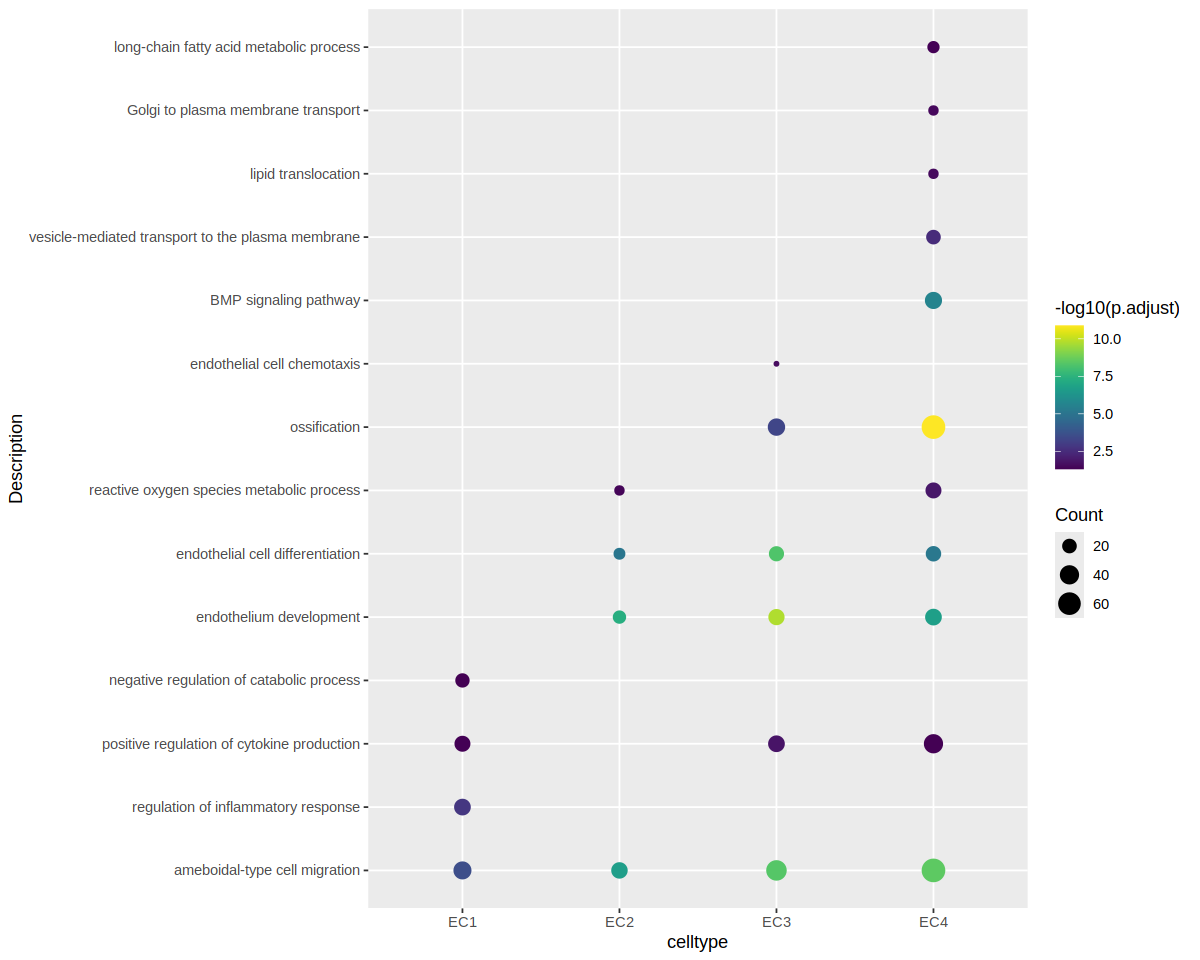

In [14]:
# GO enrichment
options(repr.plot.width = 10, repr.plot.height = 8)
merged_go_results_significant <- read.table("./meta/EC_sub_CTRL_celltype_markers_GO_BP_significant.tsv", sep = '\t', header = T, check.names = F, stringsAsFactors = F)
merged_go_results_significant <- merged_go_results_significant[order(merged_go_results_significant$celltype), ]

top_go_terms_selected <- c('ossification','reactive oxygen species metabolic process','long-chain fatty acid metabolic process','lipid translocation','vesicle-mediated transport to the plasma membrane','Golgi to plasma membrane transport','endothelial cell chemotaxis','BMP signaling pathway','Ossification','endothelium development','endothelial cell differentiation','positive regulation of cytokine production','ameboidal-type cell migration','regulation of inflammatory response','negative regulation of catabolic process')
go_bp_selected <- merged_go_results_significant[which(merged_go_results_significant$Description %in% top_go_terms_selected), ]
go_bp_selected$Description <- factor(go_bp_selected$Description, levels = unique(go_bp_selected$Description))

ggplot(go_bp_selected, aes(x = celltype, y = Description, color = -log10(p.adjust), size = Count)) + geom_point() + scale_color_viridis()
ggsave("./figure/EC_sub_celltype_GO_annotation_cytokine_chemokine.pdf", width = 6, height = 4)

Selecting by gene


[1] "Your cluster annotation color is:" "#B969E5FF"                        
[3] "#BD94EDFF"                         "#E6C0FBFF"                        
[5] "#E477F5FF"                        


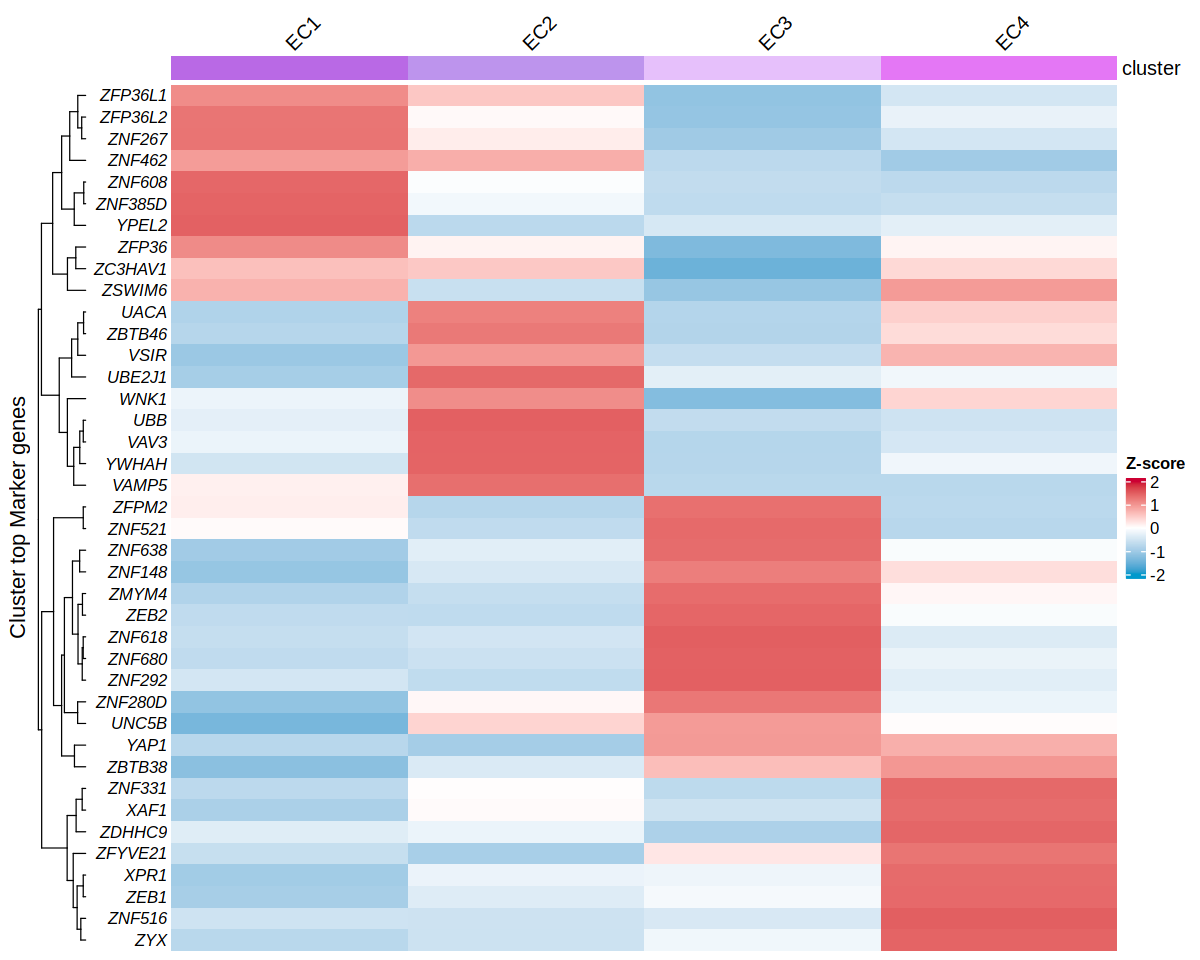

In [16]:
# heatmap
library(scRNAtoolVis)

marker_top10 <- markers_seurat_significant %>% group_by(cluster) %>% top_n(10)

sample$celltype_EC <- as.character(sample$celltype_EC)
sample$celltype_EC <- factor(sample$celltype_EC, levels = c("EC1","EC2","EC3","EC4"))
Idents(sample) <- sample$celltype_EC
averageHeatmap(object = sample, cluster_rows = T, markerGene = unique(marker_top10$gene))

In [17]:
# cytokine and chemokine heatmap
cytokine_genes <- unique(c('ACKR1','CCL14','PLVAP','IL1R1','IL6ST','EGR1','CCL23','CD74','SAMHD1','UGCG','TNFRSF1A','IL6','NFKBIZ','JAK1','IL3RA','TNFAIP3','PTK2B','IL33','LIMS1','HSPA1A','IL1RL2','FZD4','IRF1','SLC1A1','LIFR','CCL2','ROBO1','NFKBIA','SP100','AKAP12','IL1R1','IL6ST','IFI16','EGR1','CD74','HLA-DPA1','LY96','HSPD1','HLA-DPB1','RPS3','IL6','CD14','CD55','DDX21','ATF4','IL33','BCL3','HSPA1A','IL1RL2','IRF1','HGF','HSP90AA1','PNP','ABL1','CD36','BST2','B2M','CD81','GPRC5B','UBE2J1','RHOB','STMN1','CALM1','SNX18','SNX9','EXOC2','CDC14B','IGF1R','PLK3','AHCTF1','RHOC','EXOC6','PLEC','UVRAG','EXOC6B','RHOB','STMN1','SNX18','SNX9','EXOC2','RHOC','EXOC6','EXOC6B','DENND1B','RSAD2','CD81'))
chemokine_genes <- unique(c('NRP2','SEMA6A','FLRT2','SEMA4A','SEMA3E','ROBO1','EDNRB','CXCL12','PDGFD','PDGFB','RIN3','KDR','ITGA1','PREX1','RAC1','LGALS3','CX3CL1','WNK1','HBEGF','VAV3','PRKD1','ITGA9','CXCL12','PDGFB','KDR','CDH13','LGALS3','CX3CL1','CXCL12','PDGFD','PDGFB','KDR','RAC1','CDH13','WNK1','PRKD1','SEMA3G','VEGFC','FGF2','CXCL12','EFNB2','DUSP1','CDH13','PDGFD','NEDD9','MTUS1','SWAP70','FGF18','PTK2','THBS1','RIN3','SMAD3','MET','ANGPT2','GAS6','CAMK1D','S1PR1','VEGFC','FGF2','CXCL12','DUSP1','PREX1','PDGFD','NEDD9','MTUS1','CXCL2','SWAP70','CXCL3','FGF18','PTK2','CX3CL1','THBS1','RIN3','MET','PDE4B','PARVA','GAS6','CAMK1D','S1PR1','PLEC','NR4A1','MMP2','VEGFC','FGF2','CXCL12','CDH13','PTPRJ','CX3CL1','SMAD3','MET','ANGPT2','S1PR1','PDGFD','FGF2','GAS6','EDN1','SEMA5A','CMKLR1','THBS1','RIPOR2','SERPINE1','FGF18','ANO6','VEGFC','STK39','CAMK1D','CDH13','BMPR2','MDK','TGFB1','CALR','PTK2','MCU','PRKD1','PDGFD','FGF2','MMP2','GAS6','EDN1','SEMA5A','CMKLR1','THBS1','ABCC1','CXCL2','RIPOR2','SERPINE1','MMP28','PARVA','FGF18','ANO6','VEGFC','LOX','STK39','CAMK1D','CXCL3','VCAM1','BSG','MDK','CALR','PTK2','MCU','MTUS1','PRKD1','PPIB','LYST','EFNA5','NTN1','NRG1','SEMA5A','PLXNA4','SEMA7A','ITGAV','SEMA3F'))
pdf('./figure/cytokine_chemokine_heatmap.pdf', width = 6, height = 6)
averageHeatmap(object = sample, cluster_rows = T, markerGene = unique(c(cytokine_genes, chemokine_genes)), showRowNames = F)
dev.off()

[1] "Your cluster annotation color is:" "#B969E5FF"                        
[3] "#BD94EDFF"                         "#E6C0FBFF"                        
[5] "#E477F5FF"                        


png 
  2

In [18]:
# cytokine and chemokine heatmap
Idents(sample) <- sample$celltype_EC
cytokine_chemo_genes_raw <- merged_go_results_significant$geneID[grep(pattern = "cytok|Cytok|chemo|Chemo", x = merged_go_results_significant$Description)]
cytokine_chemo_genes <- unique(unlist(lapply(cytokine_chemo_genes_raw, strsplit, split = "/")))
annoGene <- c('DUSP1','NEDD9','PELI1','VEGFC','NR4A1','SEMA3G','SWAP70','EFNB2','ANGPT2','CX3CL1','CD46','NR4A3','IFNGR1','PDE4B','PTGER4','SMAD3','RHOB')
pdf('./figure/cytokine_chemokine_heatmap_highlighted.pdf', width = 6, height = 7)
averageHeatmap(object = sample, cluster_rows = T, markerGene = c(cytokine_chemo_genes, "SPP1"), showRowNames = F, markGenes = annoGene, annoCol = TRUE, myanCol = c('#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'))
dev.off()

png 
  2

In [19]:
# extract average expression for features
cytokine_chemo_genes_avg_exp <- AverageExpression(sample, features = c(cytokine_chemo_genes,"SPP1"), group.by = "ident", assays = "RNA", slot = "data")
write.csv(cytokine_chemo_genes_avg_exp$RNA, "meta_final/cytokine_chemo_genes_avg_exp_EC_DCM.csv")

In [20]:
# cytokine and chemokine violin plot
genes <- unique(c(cytokine_genes, chemokine_genes, cytokine_chemo_genes, 'SPP1'))

for (gene in genes) {
    VlnPlot(sample, features = gene, cols = c('#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'))
    ggsave(paste0("./figure/vlnplot/", gene, ".pdf"), width = 4, height = 3)
}

In [21]:
# list the session info
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/zju/ty/miniconda/envs/singlecell/lib/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scRNAtoolVis_0.1.0    lubridate_1.9.3       forcats_1.0.0        
 [4] stringr_1.5.0         purrr_1.0.2           readr_2.1.4          
 [7] tidyr_1.3.1           tibble_3.2.1          tidyverse_2.0.0   